# 1D CNN Model on the raw audio data

### loading the dependencies

In [ ]:

#* libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
def custom_pad_raw_audio(audio, fixed_length):
    padded = np.zeros(fixed_length)  #* zero-filled array
    length_to_copy = min(len(audio), fixed_length)
    padded[:length_to_copy] = audio[:length_to_copy]
    return padded

raw_audio_length = 16000

### limit cpu usage

In [5]:
# Limit CPU usage for TensorFlow
import tensorflow as tf
import multiprocessing

# Get number of available CPU cores
num_cpu = multiprocessing.cpu_count()
num_cpu_to_use = int(num_cpu * 0.7)  # Use 70% of available CPUs

# Configure TensorFlow to use specific number of threads
tf.config.threading.set_intra_op_parallelism_threads(num_cpu_to_use)
tf.config.threading.set_inter_op_parallelism_threads(num_cpu_to_use)

print(f"Total CPUs: {num_cpu}, Using: {num_cpu_to_use} (70%)")

# For memory limitation
import resource
import psutil

# Get total system memory
try:
    total_memory = psutil.virtual_memory().total
    memory_limit = int(total_memory * 0.7)  # 70% of memory
    
    # Set soft limit
    resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))
    print(f"System memory limited to {memory_limit/(1024**3):.2f} GB (70%)")
except Exception as e:
    print(f"Could not set memory limit: {e}")
    
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # For GPU devices, we can use memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s), memory growth enabled")
    except Exception as e:
        print(f"Error configuring GPUs: {e}")

Total CPUs: 8, Using: 5 (70%)
Could not set memory limit: current limit exceeds maximum limit


### inintalize model

In [40]:
from tensorflow.keras.utils import to_categorical

# Reload the train_df to make sure we have the original data
train_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'
train_files = os.listdir(train_dir)

train_df = pd.DataFrame(train_files, columns=['file'])
train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(train_dir, x))
train_df['file_name'] = train_df['file'].str.replace('.wav', '')
train_df['accent'] = train_df['file_name'].str[0]
train_df['gender'] = train_df['file_name'].str[1]

df_raw = train_df.copy()

#* process raw audio data
X_raw = []
y_raw = []

for data in tqdm(df_raw.iterrows(), desc='Raw Audio Progress'):
    file_path = os.path.join(train_dir, data[1]['file'])  # Fixed: use train_dir instead of data_dir
    audio, sr = librosa.load(file_path, sr=16000)
    
    #* z-score standardization
    audio = (audio - np.mean(audio)) / (np.std(audio) + 1e-8)
    
    #* padding to fixed length
    padded_audio = custom_pad_raw_audio(audio, raw_audio_length)
    
    X_raw.append(padded_audio)
    y_raw.append(data[1]['accent'])  # Use accent from original dataframe

# Convert to numpy arrays
X_raw = np.array(X_raw)
y_raw = np.array(y_raw, dtype=int)

# Prepare labels
y_raw = y_raw.astype(int) - 1
y_raw = to_categorical(y_raw, num_classes=5)

#* reshpae for a 1D CNN
X_raw = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)

#* train/validation/test split 
X_raw_temp, X_raw_test, y_raw_temp, y_raw_test = train_test_split(
    X_raw, y_raw, test_size=0.15, random_state=42, stratify=y_raw
)

X_raw_train, X_raw_val, y_raw_train, y_raw_val = train_test_split(
    X_raw_temp, y_raw_temp, test_size=0.176, random_state=42, stratify=y_raw_temp 
)

#* create dataframes with file infor for each split
temp_indices = list(range(len(df_raw)))

#! Split indices same way as data
temp_train_idx, test_idx = train_test_split(
    temp_indices, test_size=0.15, random_state=42, 
    stratify=[df_raw.iloc[i]['accent'] for i in temp_indices]
)

train_idx, val_idx = train_test_split(
    temp_train_idx, test_size=0.176, random_state=42,
    stratify=[df_raw.iloc[i]['accent'] for i in temp_train_idx]
)

#* create dataframe with file info and arrays
test_set_df = df_raw.iloc[test_idx].copy().reset_index(drop=True)

#* add audio arrays to dataframes
test_set_df['audio_array'] = list(X_raw_test)

test_set_df['predicted_accent'] = None




print(f"Raw audio training set: {X_raw_train.shape[0]} samples")
print(f"Raw audio validation set: {X_raw_val.shape[0]} samples") 
print(f"Raw audio test set: {X_raw_test.shape[0]} samples")
print(f"\nDataframes created:")

print(f"Test set dataframe: {test_set_df.shape[0]} samples")


Raw Audio Progress: 3166it [00:04, 652.73it/s]


Raw audio training set: 2217 samples
Raw audio validation set: 474 samples
Raw audio test set: 475 samples

Dataframes created:
Test set dataframe: 475 samples


In [47]:
test_set_df

,file,file_path,file_name,accent,gender,audio_array,predicted_accent,prediction_confidence
0,5f_8431.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_8431,5,f,"[[-0.0007164341513998806], [-7.327915955102071...",2,0.816028
1,5f_3560.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_3560,5,f,"[[-0.006885554175823927], [-0.0068855541758239...",4,0.729837
2,4f_9833.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9833,4,f,"[[0.0010449393885210156], [0.00420673191547393...",4,0.665087
3,1f_9293.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1f_9293,1,f,"[[-0.004357101861387491], [-0.0056317741982638...",4,0.630621
4,2f_8352.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2f_8352,2,f,"[[-0.0011133668012917042], [-0.001574276597239...",5,0.403265
...,...,...,...,...,...,...,...,...
470,4m_7980.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4m_7980,4,m,"[[0.0014999943086877465], [0.00096733926329761...",4,0.862518
471,3m_7926.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3m_7926,3,m,"[[-0.001725443871691823], [-0.0028165169060230...",4,0.965305
472,3f_7895.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3f_7895,3,f,"[[-0.006140249315649271], [-0.0061402493156492...",4,0.960227
473,5f_7459.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_7459,5,f,"[[0.0005547950277104974], [0.00203530327416956...",2,0.622169


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'accent: 2, gender: m')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 4, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 1, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 3, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 5, gender: f')

(-1.0, 1.0)

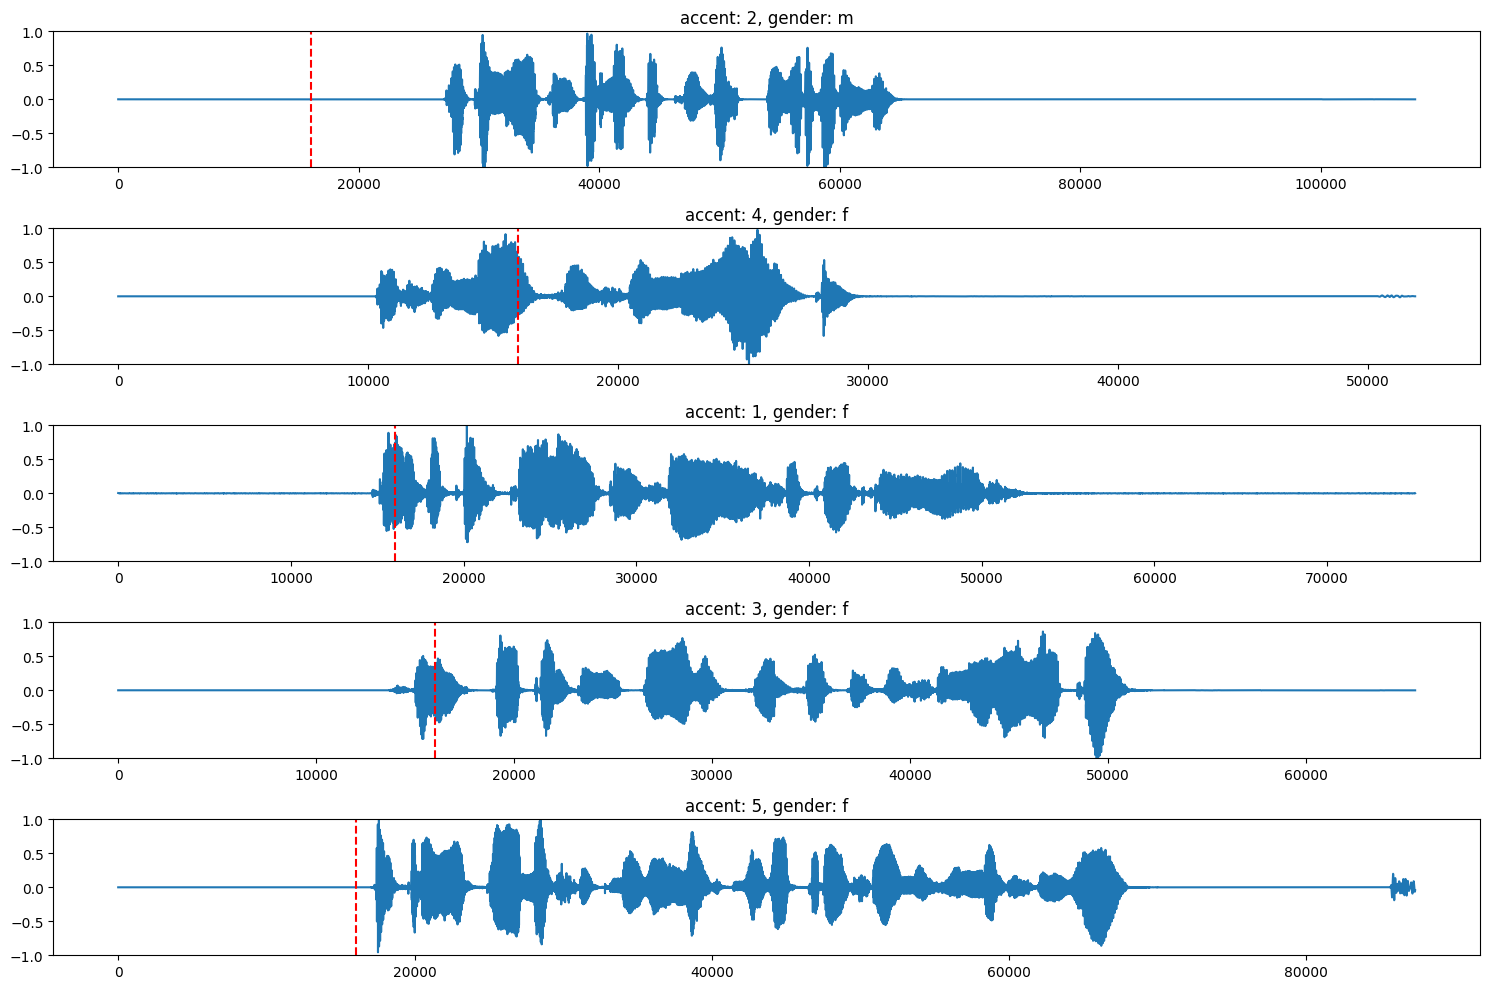

In [12]:
#* visualize raw waveforms from different accents
plt.figure(figsize=(15, 10))

#* plot one example per accent
for i, accent in enumerate(train_df['accent'].unique()):
    #* get one sample from this accent
    sample = train_df[train_df['accent'] == accent].sample(1).iloc[0]
    audio, sr = librosa.load(sample['file_path'], sr=16000)  # Fixed: use consistent sr=16000
    
    #* normalize for visualization
    audio = audio / np.max(np.abs(audio))
    
    #* plot waveform
    plt.subplot(len(train_df['accent'].unique()), 1, i+1)
    plt.plot(audio)
    plt.title(f"accent: {sample['accent']}, gender: {sample['gender']}")
    plt.ylim([-1, 1])
    
    #* add vertical line at 1 second (16000 samples at 16kHz)
    if len(audio) > 16000:
        plt.axvline(x=16000, color='r', linestyle='--', label='1 second')

plt.tight_layout()
plt.savefig('raw_audio_waveforms.png', dpi=300, bbox_inches='tight')
plt.show()

### 1D CNN 

In [21]:
#* define model architecture for raw audio
#* Conv1D uses the glorot_uniform weight initialization technique as its default 
def create_raw_audio_model(input_shape, num_classes=5):
    model = models.Sequential([
        #* first conv block
        layers.Conv1D(16, 64, strides=2, padding='same', input_shape=input_shape),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=8, strides=8),
        layers.BatchNormalization(),
        
        #* second conv block
        layers.Conv1D(32, 32, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        #* third conv block
        layers.Conv1D(64, 16, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        #* fourth conv block
        layers.Conv1D(128, 8, padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.BatchNormalization(),
        
        #* flatten and dense layers
        layers.Flatten(),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Keep softmax for final output
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#* create model instance
raw_audio_model = create_raw_audio_model((raw_audio_length, 1))
raw_audio_model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8000, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 500, 32)        │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 63, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,829 (1.33 MB)

 Trainable params: 347,349 (1.33 MB)

 Non-trainable params: 480 (1.88 KB)

In [22]:

#* train the model
raw_audio_history = raw_audio_model.fit(
    X_raw_train, y_raw_train,
    validation_data=(X_raw_val, y_raw_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2262 - loss: 2.2097 - val_accuracy: 0.2764 - val_loss: 1.5876
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3050 - loss: 1.7580 - val_accuracy: 0.2932 - val_loss: 1.5726
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.3713 - loss: 1.5197 - val_accuracy: 0.3312 - val_loss: 1.5264
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.3928 - loss: 1.4050 - val_accuracy: 0.2806 - val_loss: 1.5628
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4416 - loss: 1.3213 - val_accuracy: 0.3354 - val_loss: 1.4367
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4765 - loss: 1.2307 - val_accuracy: 0.3354 - val_loss: 1.4619
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5236 - loss: 1.1439 - val_accuracy: 0.2911 - val_loss: 1.7082
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5379 - loss: 1.0846 - val_accuracy: 0.2932 - v

In [ ]:
#* evaluate model performance on FINAL test set
raw_audio_final_loss, raw_audio_final_acc = raw_audio_model.evaluate(X_raw_test, y_raw_test, verbose=1)
print(f"raw audio model - FINAL test loss: {raw_audio_final_loss:.4f}")
print(f"raw audio model - FINAL test accuracy: {raw_audio_final_acc:.4f}")

#* plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(raw_audio_history.history['accuracy'], label='train accuracy')
plt.plot(raw_audio_history.history['val_accuracy'], label='validation accuracy')
plt.title('raw audio model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(raw_audio_history.history['loss'], label='train loss')
plt.plot(raw_audio_history.history['val_loss'], label='validation loss')
plt.title('raw audio model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.savefig('raw_audio_model_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = [str(i+1) for i in range(5)] 
#* generate predictions
y_raw_pred = raw_audio_model.predict(X_raw_test)
y_raw_pred_classes = np.argmax(y_raw_pred, axis=1)
y_raw_true_classes = np.argmax(y_raw_test, axis=1)

#* create confusion matrix
raw_cm = confusion_matrix(y_raw_true_classes, y_raw_pred_classes)

#* plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(raw_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('confusion matrix - raw audio model')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.tight_layout()
plt.savefig('raw_audio_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### hyperparemeter search

In [ ]:
#* simple hyperparameter experimentation
param_grid = {
    'conv1_filters': [16, 32],           
    'dense_units': [128, 256],           
    'dropout_rate': [0.3, 0.5],          
    'learning_rate': [0.001, 0.0005]     
}

def create_model_with_params(conv1_filters, dense_units, dropout_rate, learning_rate):
    model = models.Sequential([
        layers.Conv1D(conv1_filters, 64, strides=2, padding='same', input_shape=(raw_audio_length, 1)),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=8, strides=8),
        layers.BatchNormalization(),
        
        layers.Conv1D(conv1_filters*2, 32, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        layers.Conv1D(conv1_filters*4, 16, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        layers.Conv1D(128, 8, padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(dense_units),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(dropout_rate),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#* test different parameter combinations
results = []

for conv1_filters in param_grid['conv1_filters']:
    for dense_units in param_grid['dense_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                
                print(f"Testing: filters={conv1_filters}, dense={dense_units}, dropout={dropout_rate}, lr={learning_rate}")
                
                model = create_model_with_params(conv1_filters, dense_units, dropout_rate, learning_rate)
                
                history = model.fit(
                    X_raw_train, y_raw_train,
                    validation_data=(X_raw_val, y_raw_val),
                    epochs=10,
                    batch_size=32,
                    verbose=0
                )
                
                val_acc = max(history.history['val_accuracy'])
                
                results.append({
                    'conv1_filters': conv1_filters,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'val_accuracy': val_acc
                })
                
                print(f"Validation accuracy: {val_acc:.4f}")

#* find best parameters
best_result = max(results, key=lambda x: x['val_accuracy'])

print("\nBest parameters:")
print(f"Conv1 filters: {best_result['conv1_filters']}")
print(f"Dense units: {best_result['dense_units']}")
print(f"Dropout rate: {best_result['dropout_rate']}")
print(f"Learning rate: {best_result['learning_rate']}")
print(f"Best validation accuracy: {best_result['val_accuracy']:.4f}")

#* train final model with best parameters
print("\nTraining final model with best parameters...")
final_model = create_model_with_params(
    best_result['conv1_filters'],
    best_result['dense_units'], 
    best_result['dropout_rate'],
    best_result['learning_rate']
)

final_history = final_model.fit(
    X_raw_train, y_raw_train,
    validation_data=(X_raw_val, y_raw_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

#* evaluate final model
test_loss, test_acc = final_model.evaluate(X_raw_test, y_raw_test)
print(f"Final test accuracy: {test_acc:.4f}")

Testing: filters=16, dense=128, dropout=0.3, lr=0.001
Validation accuracy: 0.4072
Testing: filters=16, dense=128, dropout=0.3, lr=0.0005
Validation accuracy: 0.4958
Testing: filters=16, dense=128, dropout=0.5, lr=0.001
Validation accuracy: 0.4177
Testing: filters=16, dense=128, dropout=0.5, lr=0.0005
Validation accuracy: 0.3987
Testing: filters=16, dense=256, dropout=0.3, lr=0.001
Validation accuracy: 0.3397
Testing: filters=16, dense=256, dropout=0.3, lr=0.0005
Validation accuracy: 0.4641
Testing: filters=16, dense=256, dropout=0.5, lr=0.001
Validation accuracy: 0.3713
Testing: filters=16, dense=256, dropout=0.5, lr=0.0005
Validation accuracy: 0.4177
Testing: filters=32, dense=128, dropout=0.3, lr=0.001
Validation accuracy: 0.3882
Testing: filters=32, dense=128, dropout=0.3, lr=0.0005
Validation accuracy: 0.4093
Testing: filters=32, dense=128, dropout=0.5, lr=0.001
Validation accuracy: 0.4219
Testing: filters=32, dense=128, dropout=0.5, lr=0.0005
Validation accuracy: 0.4008
Testing: f

Evaluating best model on validation set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3939 - loss: 2.2824
Best model - Validation loss: 2.2640
Best model - Validation accuracy: 0.3987

Comparison:
Original model - Validation accuracy: 0.4451
Best model - Validation accuracy: 0.3987
Improvement: -0.0464
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Validation Set - Confusion Matrix (Best Model)')

Text(70.72222222222221, 0.5, 'True Label')

Text(0.5, 36.72222222222221, 'Predicted Label')

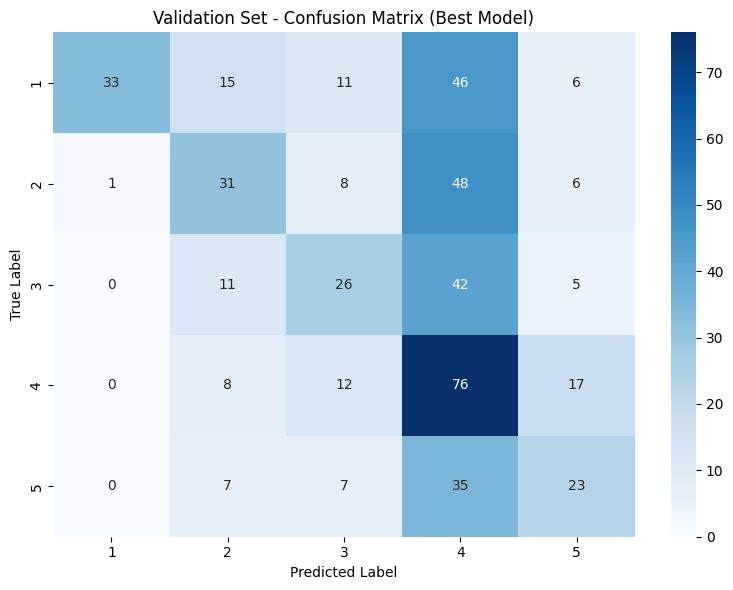


Validation Set Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.30      0.46       111
           2       0.43      0.33      0.37        94
           3       0.41      0.31      0.35        84
           4       0.31      0.67      0.42       113
           5       0.40      0.32      0.36        72

    accuracy                           0.40       474
   macro avg       0.50      0.39      0.39       474
weighted avg       0.52      0.40      0.40       474



In [28]:
#* evaluate the best model on validation set
print("Evaluating best model on validation set...")
val_loss, val_acc = final_model.evaluate(X_raw_val, y_raw_val, verbose=1)
print(f"Best model - Validation loss: {val_loss:.4f}")
print(f"Best model - Validation accuracy: {val_acc:.4f}")

#* compare with original model
print("\nComparison:")
print(f"Original model - Validation accuracy: {max(raw_audio_history.history['val_accuracy']):.4f}")
print(f"Best model - Validation accuracy: {val_acc:.4f}")
print(f"Improvement: {val_acc - max(raw_audio_history.history['val_accuracy']):.4f}")

#* generate detailed predictions on validation set
val_predictions = final_model.predict(X_raw_val)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_raw_val, axis=1)

#* validation confusion matrix
val_cm = confusion_matrix(val_true_classes, val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Set - Confusion Matrix (Best Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('best_model_validation_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#* classification report
print("\nValidation Set Classification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=class_names))

### predict accent and gener on test data

In [45]:

#* predict accents for test set using the best model
accent_predictions = final_model.predict(np.array(test_set_df['audio_array'].tolist()))
test_pred_classes = np.argmax(accent_predictions, axis=1) #* get the class with the highest probability

#* add a predction confidence column
test_set_df['prediction_confidence'] = np.max(accent_predictions, axis=1)
test_set_df['predicted_accent'] = test_pred_classes + 1  #* convert back to original accent labels (1-5)



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [49]:
test_set_df.head()

,file,file_path,file_name,accent,gender,audio_array,predicted_accent,prediction_confidence
0,5f_8431.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_8431,5,f,"[[-0.0007164341513998806], [-7.327915955102071...",2,0.816028
1,5f_3560.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_3560,5,f,"[[-0.006885554175823927], [-0.0068855541758239...",4,0.729837
2,4f_9833.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9833,4,f,"[[0.0010449393885210156], [0.00420673191547393...",4,0.665087
3,1f_9293.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1f_9293,1,f,"[[-0.004357101861387491], [-0.0056317741982638...",4,0.630621
4,2f_8352.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2f_8352,2,f,"[[-0.0011133668012917042], [-0.001574276597239...",5,0.403265


=== MODEL PERFORMANCE BY ACCENT ===
             Sample_Count  Accuracy  Avg_Confidence
true_accent                                        
1                     111     0.252           0.694
2                      94     0.330           0.723
3                      85     0.471           0.818
4                     113     0.708           0.745
5                      72     0.278           0.745

=== MODEL PERFORMANCE BY GENDER ===
        Sample_Count  Accuracy  Avg_Confidence
gender                                        
f                245     0.424           0.749
m                230     0.413           0.735

=== MODEL PERFORMANCE BY ACCENT AND GENDER ===
                    correct_prediction
true_accent gender                    
1           f                    0.232
            m                    0.273
2           f                    0.327
            m                    0.333
3           f                    0.432
            m                    0.512
4           f  

<Axes: xlabel='true_accent'>

Text(0.5, 1.0, 'Model Accuracy by Accent')

Text(0.5, 0, 'Accent')

Text(0, 0.5, 'Accuracy')

(0.0, 1.0)

<Axes: xlabel='gender'>

Text(0.5, 1.0, 'Model Accuracy by Gender')

Text(0.5, 0, 'Gender')

Text(0, 0.5, 'Accuracy')

(0.0, 1.0)

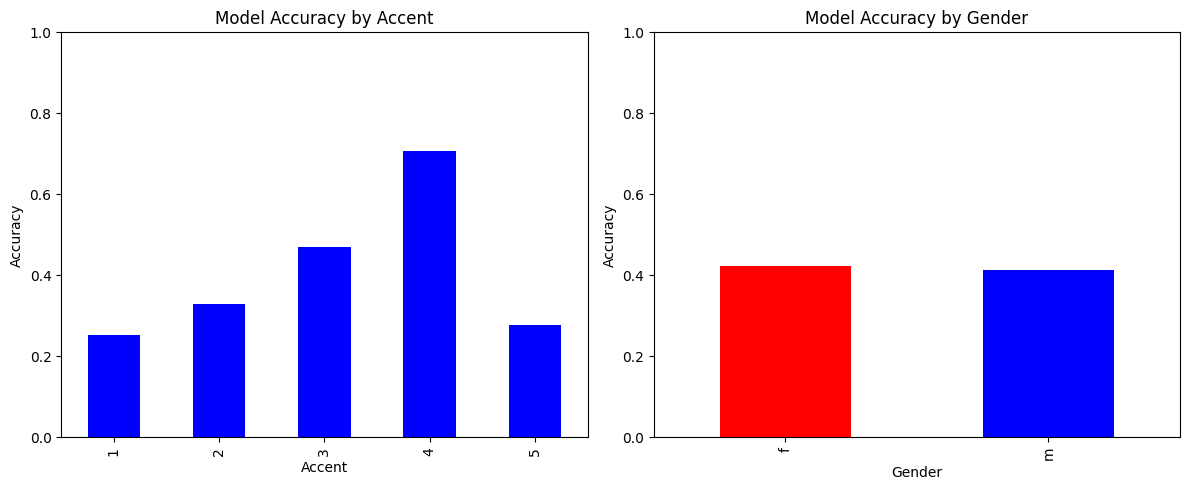

In [52]:
#* Error Analysis Table and Figure for Accent and Gender Performance

# Create analysis dataframe
test_analysis_df = test_set_df.copy()
test_analysis_df['true_accent'] = [np.argmax(y) + 1 for y in y_raw_test]
test_analysis_df['correct_prediction'] = (test_analysis_df['true_accent'] == test_analysis_df['predicted_accent'])

# Performance by Accent
accent_performance = test_analysis_df.groupby('true_accent').agg({
    'correct_prediction': ['count', 'mean'],
    'prediction_confidence': 'mean'
}).round(3)
accent_performance.columns = ['Sample_Count', 'Accuracy', 'Avg_Confidence']

# Performance by Gender  
gender_performance = test_analysis_df.groupby('gender').agg({
    'correct_prediction': ['count', 'mean'],
    'prediction_confidence': 'mean'
}).round(3)
gender_performance.columns = ['Sample_Count', 'Accuracy', 'Avg_Confidence']

# Combined Accent-Gender Performance
combined_performance = test_analysis_df.groupby(['true_accent', 'gender']).agg({
    'correct_prediction': 'mean'
}).round(3)

print("=== MODEL PERFORMANCE BY ACCENT ===")
print(accent_performance)

print("\n=== MODEL PERFORMANCE BY GENDER ===")
print(gender_performance)

print("\n=== MODEL PERFORMANCE BY ACCENT AND GENDER ===")
print(combined_performance)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy by Accent
accent_performance['Accuracy'].plot(kind='bar', ax=ax1, color='blue')
ax1.set_title('Model Accuracy by Accent')
ax1.set_xlabel('Accent')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)

# Accuracy by Gender
gender_performance['Accuracy'].plot(kind='bar', ax=ax2, color=['red', 'blue'])
ax2.set_title('Model Accuracy by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('accent_gender_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# predict accent on the test folder data

In [29]:
#* predict on the test directory
test_dir = '/Users/kaispeidel/Downloads/DeepLearning/Test'
test_files = os.listdir(test_dir)

test_df = pd.DataFrame(test_files, columns=['file'])
test_df['file_path'] = test_df['file'].apply(lambda x: os.path.join(test_dir, x))
test_df['file_name'] = test_df['file'].str.replace('.wav', '')

test_df.head()


,file,file_path,file_name
0,9430.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,9430
1,4458.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4458
2,1534.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,1534
3,8510.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8510
4,7192.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,7192


In [54]:
print(f"-----"*10)
#* predict the accents for the test set
X_test = []

print("processing test files...")
for i, row in test_df.iterrows():
    file_path = row['file_path']
    audio, sr = librosa.load(file_path, sr=16000)
    
    #* same preprocessing as training data
    audio = (audio - np.mean(audio)) / (np.std(audio) + 1e-8)
    padded_audio = custom_pad_raw_audio(audio, raw_audio_length)
    
    X_test.append(padded_audio)

#* convert to numpy array and reshape for CNN
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Test data shape: {X_test.shape}")

#* make predictions using the trained model
predictions = final_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

#* convert back to accent labels (1-5)
predicted_accents = predicted_classes + 1

#* add predictions to test dataframe
test_df['predicted_accent_1D_CNN_raw_audio'] = predicted_accents

#* show results
print(f"\nPrediction results:")
print(test_df[['file', 'predicted_accent_1D_CNN_raw_audio']].head(10))

#* save predictions to CSV
test_df[['file', 'predicted_accent_1D_CNN_raw_audio']].to_csv('test_accent_predictions.csv', index=False)
print(f"\nPredictions saved to 'test_predictions.csv'")

#* show distribution of predicted accents
accent_counts = test_df['predicted_accent_1D_CNN_raw_audio'].value_counts().sort_index()
print(f"\nPredicted accent distribution:")
for accent, count in accent_counts.items():
    print(f"Accent {accent}: {count} files")

--------------------------------------------------
processing test files...
Test data shape: (551, 16000, 1)
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Prediction results:
       file  predicted_accent_1D_CNN_raw_audio
0  9430.wav                                  4
1  4458.wav                                  4
2  1534.wav                                  1
3  8510.wav                                  4
4  7192.wav                                  4
5  2607.wav                                  4
6  1468.wav                                  4
7  5626.wav                                  3
8  9949.wav                                  3
9  5815.wav                                  4

Predictions saved to 'test_predictions.csv'

Predicted accent distribution:
Accent 1: 41 files
Accent 2: 62 files
Accent 3: 98 files
Accent 4: 284 files
Accent 5: 66 files
